In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../..')
from laplace_coeff_Thomas import *
from datanew import *
from array import *

# needed for the laplace coefficients from the lookup table
cfs=LaplaceCoeffs()
dcfs=LaplaceCoeffsDerivatives()
d2cfs=LaplaceCoeffs2Derivatives()

In [2]:
# Konstanten Einheitenlos
M_STAR=1
MU1=3e-3
MU2=1e-3
M1=MU1*M_STAR
M2=MU2*M_STAR
mmr=2
G=1
R_0=1 #1 au

SIGMA_0=1e-3
SIGMASLOPE=1.5

ALPHAVISCOSITY=1e-3     
TSLOPE=0.5           
FLARINGINDEX=0.25
H_0=0.06
SIGMARATIO=0.1   #for kanagawa

R_IN=np.arange(1,5,0.001)
R_OUT=R_IN *mmr**(2/3)

ec=0.1

# Torque rechnungen 

In [4]:
#width of the gap
def deltain(r,mu,Sigmaratio):
    b= (0.5*Sigmaratio+0.16)
    
    c=(mu**2)
    c*=(aspect_ratio(r)) **(-3)
    c*=ALPHAVISCOSITY**(-1)

    return r*b*c**(0.25) 

In [5]:
def omega_kepler(r):
    return np.sqrt(G*M_STAR/(r**3))

def surface_density(r):
    return SIGMA_0* (r/R_0)**(-SIGMASLOPE)

def aspect_ratio(r):
    return H_0 *(r/R_0)**FLARINGINDEX

#cutoff radius
def r_lim_k(r):
    return r-aspect_ratio(r)*r *2/3 ,r+aspect_ratio(r)*r *2/3

In [6]:
# Matrix of Lindblad locations with the consideration of the gap width and the cutoff radius, for l=m
def r_Llist(m,rp):
    
    rvin = ((-1/m + 1)**(2/3) * rp[:,None])
    rvin=np.where(rvin==0, np.nan, rvin)
    rvout = (( 1/m + 1)**(2/3) * rp[:,None])
    
    r1, r2 = r_lim_k(rp)
    r1, r2 = r1[:,None], r2[:,None]
    

    delta_in = deltain(rp, MU1, SIGMARATIO)/2
    delta_out = deltain(rp, MU2, SIGMARATIO)/2
    
    finalin = np.where(rvin  < (rp - delta_in)[:,None], rvin, np.nan)
    finalin =  np.where(finalin != np.nan,np.where(finalin >= r1, r1, finalin),np.nan)
    
    finalout= np.where(rvout > (rp + delta_out)[:,None], rvout, np.nan)
    finalout= np.where(finalout != np.nan,np.where(finalout <= r2, r2, finalout), np.nan)
        
    return finalin, finalout

In [7]:
# Matrix of Lindblad locations with the consideration of the gap width and the cutoff radius, for l =/ m

def r_Llistlm(m,rp):
    
    rvin = ((m -1)/(m + 1))**(2/3) * rp[:,None]
    rvout = ((m +1)/(m -1))**(2/3) * rp[:,None]
    
    #print(f'{rvout =}')
    
    r1, r2 = r_lim_k(rp)
    r1, r2 = r1[:,None], r2[:,None]
    

    delta_in = deltain(rp, MU1, SIGMARATIO)/2
    delta_out = deltain(rp, MU2, SIGMARATIO)/2

    finalin = np.where(rvin  < (rp - delta_in)[:,None], rvin, np.nan)
    finalin =  np.where(finalin != np.nan,np.where(finalin >= r1, r1, finalin),np.nan)
    
    finalout= np.where(rvout > (rp + delta_out)[:,None], rvout, np.nan)
    finalout= np.where(finalout != np.nan,np.where(finalout <= r2, r2, finalout), np.nan)
        
    return finalin, finalout

In [8]:
# List, one value of Lindblad locations with the consideration of the gap width and the cutoff radius, for l=m
def r_Lvalue(m,rp):
    
    rvin = ((-1/m + 1)**(2/3) * rp)
    rvin=np.where(rvin==0, np.nan, rvin)
    rvout = (( 1/m + 1)**(2/3) * rp)
    
    r1, r2 = r_lim_k(rp)
    
    delta_in = deltain(rp, MU1, SIGMARATIO)/2
    delta_out = deltain(rp, MU2, SIGMARATIO)/2
   
    finalin = np.where(rvin  < (rp - delta_in), rvin, np.nan)
    finalin =  np.where(finalin != np.nan,np.where(finalin >= r1, r1, finalin),np.nan)
    
    finalout= np.where(rvout > (rp + delta_out), rvout, np.nan)
    finalout= np.where(finalout != np.nan,np.where(finalout <= r2, r2, finalout), np.nan)
        
    return finalin, finalout



In [9]:
# List, one value of Lindblad locations with the consideration of the gap width and the cutoff radius, for l=/m
def r_Lvaluelm(m,rp):
    
    rvin = ((m -1)/(m+ 1))**(2/3) * rp
    rvout = ((m +1)/(m -1))**(2/3) * rp
    
    r1, r2 = r_lim_k(rp)
    
    delta_in = deltain(rp, MU1, SIGMARATIO)/2
    delta_out = deltain(rp, MU2, SIGMARATIO)/2
   
    finalin = np.where(rvin  < (rp - delta_in), rvin, np.nan)
    finalin =  np.where(finalin != np.nan,np.where(finalin >= r1, r1, finalin),np.nan)
    
    finalout= np.where(rvout > (rp + delta_out), rvout, np.nan)
    finalout= np.where(finalout != np.nan,np.where(finalout <= r2, r2, finalout), np.nan)
        
    return finalin, finalout



In [10]:
# Functions for the Torque of Goldreich and Tremain
"""def D(r,rp,m):
    #print(np.shape(omega_kepler(r)**2))
    
    return omega_kepler(r)**2 - m**2 *(omega_kepler(r) -omega_kepler(rp))**2"""

def diffD(r,rp,m):
    rv= -3 *G*M_STAR* r**(-4)
    rv= m**2 *2 *(omega_kepler(r) -omega_kepler(rp)) * (3/2) *np.sqrt(M_STAR *G) *r**(-5/2)
    return rv


def f(rp):
    return omega_kepler(rp)**2 *rp**3 /(G*M_STAR)


def phi_11(r,rp,l,Mp):
    rv=(2*l - 2*f(rp)*r/rp)
    rv*= -G*Mp/(2*rp)
    return rv

def diff_phi_11(rp,l,Mp):
    rv=(-f(rp) + l)
    rv*=-G*Mp/(rp**2)
    
    return rv

def phi_mm(rp,l,Mp):
    rv=-G*Mp/(2*rp) *2*l
    return rv
    
def diff_phi_mm(rp,l,Mp):
    rv=-G*Mp/(rp**2) *l
    return rv

def omegalm(rp,l,m):
    return omega_kepler(rp) *(1 +(l-m)/m)
    
    
def diffDlm(r,rp,l,m):
    rv= -3 *G*M_STAR* r**(-4)
    rv= m**2 *2 *(omega_kepler(r) -omegalm(rp,l,m)) * (3/2) *np.sqrt(M_STAR *G) *r**(-5/2)
    return rv

def phi_mp1m(r,rp,m,Mp,e,laplace,dlaplace):
    rv1=- G*Mp*e/rp
    
    rv2=(1/2 +m)*laplace
    rv2+=r/(rp*2) *dlaplace
    
    return rv1 *rv2

def diffphi_mp1m(r,rp,m,Mp,e,dlaplace,d2laplace):
    rv1=- G*Mp*e/rp
    
    rv2=(1/2 +m)*1/rp*dlaplace
    rv2+=r/(rp**2 *2) *d2laplace
    rv2+= 1/(rp *2) *dlaplace
    return rv1 *rv2


def phi_mm1m(r,rp,m,Mp,e,laplace,dlaplace):
    rv1=- G*Mp*e/rp
    
    rv2=(1/2 -m)*laplace
    rv2+=r/(rp*2) *dlaplace
    
    return rv1 *rv2

def diffphi_mm1m(r,rp,m,Mp,e,dlaplace,d2laplace):
    rv1=- G*Mp*e/rp
    
    rv2=(1/2 -m)*1/rp*dlaplace
    rv2+=r/(rp**2 *2) *d2laplace
    rv2+= 1/(rp *2) *dlaplace
    
    return rv1 *rv2

In [12]:
#Inner Torque for l=m+1
def T_in_lm(m,rp,Mp,e): 
    r=r_Llist(m,rp)[0]
      
    laplace = np.zeros((len(rp),len(m)))
    dlaplace= np.zeros((len(rp),len(m)))
    d2laplace= np.zeros((len(rp),len(m)))
        
    for i in np.arange(len(m)):
        for j in np.arange(len(rp)):
            laplace[j][i] = cfs( r[j][i]/rp[j], m[i])
            dlaplace[j][i] = dcfs(r[j][i]/rp[j], m[i])
            d2laplace[j][i] = d2cfs(r[j][i]/rp[j], m[i])
    
    rv1=surface_density(r)* (r *diffDlm(r,rp[:,None],m+1,m))**(-1)
        
    omeg= omega_kepler(r)/(omega_kepler(r) -omegalm(rp[:,None],m+1,m))
    
    rv2=r *diffphi_mp1m(r,rp[:,None],m,Mp,e,laplace,dlaplace)
    rv2+= 2*omeg *phi_mp1m(r,rp[:,None],m,Mp,e,dlaplace,d2laplace)
    
    rv= -m*np.pi**2 *(rv1 *rv2**2)
    
    return np.nan_to_num((-1)*rv)

In [13]:
#Inner Torque for l=m-1
def T_out_lm(m,rp,Mp,e): #m-1
    r=r_Llist(m,rp)[1]
        
    laplace = np.zeros((len(rp),len(m)))
    dlaplace= np.zeros((len(rp),len(m)))
    d2laplace= np.zeros((len(rp),len(m)))
        
    for i in np.arange(len(m)):
        for j in np.arange(len(rp)):
            laplace[j][i] = cfs( r[j][i]/rp[j], m[i])
            dlaplace[j][i] = dcfs(r[j][i]/rp[j], m[i])
            d2laplace[j][i] = d2cfs(r[j][i]/rp[j], m[i])
    
    rv1=surface_density(r)* (r *diffDlm(r,rp[:,None],m-1,m))**(-1)
        
    omeg= omega_kepler(r)/(omega_kepler(r) -omegalm(rp[:,None],m-1,m))
    
    rv2=r *diffphi_mm1m(r,rp[:,None],m,Mp,e,laplace,dlaplace)
    rv2+= 2*omeg *phi_mm1m(r,rp[:,None],m,Mp,e,dlaplace,d2laplace)
    
    rv= -m*np.pi**2 *(rv1 *rv2**2)
    
    return np.nan_to_num((1)*rv)

In [14]:
#Inner Torque for l=m
def T_in_mm(m,rp,Mp):
    r=r_Llist(m,rp)[0]
        
    laplace = np.zeros((len(rp),len(m)))
    dlaplace= np.zeros((len(rp),len(m)))
        
    for i in np.arange(len(m)):
        for j in np.arange(len(rp)):
            laplace[j][i] = cfs( r[j][i]/rp[j], m[i])
            dlaplace[j][i] = dcfs(r[j][i]/rp[j], m[i])
            
    
    rv1=surface_density(r)* (r *diffD(r,rp[:,None],m))**(-1)
        
    omeg= omega_kepler(r)/(omega_kepler(r) -omega_kepler(rp[:,None]))
    
    rv2=r *diff_phi_mm(rp[:,None],dlaplace,Mp)
    rv2+= 2*omeg *phi_mm(rp[:,None],laplace,Mp)
        
    rv= -m*np.pi**2 *(rv1 *rv2**2)
    
    return np.nan_to_num((-1)*rv)
    

In [15]:
#Outer Torque for l=m, m=/1

def T_out_mm(m,rp,Mp):
    r=r_Llist(m,rp)[1]
        
    laplace = np.zeros((len(rp),len(m)))
    dlaplace= np.zeros((len(rp),len(m)))
        
    for i in np.arange(len(m)):
        for j in np.arange(len(rp)):
            laplace[j][i] = cfs( r[j][i]/rp[j], m[i])
            dlaplace[j][i] = dcfs(r[j][i]/rp[j], m[i])
            
    
    rv1=surface_density(r)* (r *diffD(r,rp[:,None],m))**(-1)
    
    omeg= omega_kepler(r)/(omega_kepler(r) -omega_kepler(rp[:,None]))
    
    rv2=r *diff_phi_mm(rp[:,None],dlaplace,Mp)
    rv2+= 2*omeg *phi_mm(rp[:,None],laplace,Mp)
    
    rv= -m*np.pi**2 *(rv1 *rv2**2)

    return np.nan_to_num((-1)*rv)

In [16]:
#Outer Torque for l=m, m=1
def T_out_11(rp,Mp):
    r=r_Llist(1,rp)[1]
        
    laplace = np.zeros(len(rp))
    dlaplace= np.zeros(len(rp))
        
    for j in np.arange(len(rp)):
        laplace[j] = cfs( r[j]/rp[j], 1)
        dlaplace[j]= dcfs(r[j]/rp[j],1)
            
    
    rv1=surface_density(r)* (r *diffD(r,rp[:,None],1))**(-1)

    omeg= omega_kepler(r)/(omega_kepler(r) -omega_kepler(rp[:,None]))
    
    rv2=r *diff_phi_11(rp[:,None],dlaplace,Mp)
    rv2+= 2*omeg *phi_11(r,rp[:,None],laplace,Mp)
    
    rv= -np.pi**2 *(rv1 *rv2**2)
    
    return np.nan_to_num((-1)*rv)

In [17]:
#Thomas section wise kanagawa profile
def Kanagawa17Profile(r, rp, Mp):
    """ Gap profile from Kanagawa et al. 2017 Eq. (6).
    
    This function calculates the gap shape Sigma(r)/Sigma0.
    
    Parameters
    ----------
    r : array
        Grid radii.
    rp : float
        Orbital radius of the planet.
    Mp : float
        Planet mass in units of stellar mass.
    h : float
        Aspect ratio (H/R) at the location of the planet.
    alpha : float
        Viscous alpha parameter.
        
    Returns
    -------
    array
        Reduction factor of the surface density.
    
    """
    Sigma = np.ones_like(r)
    
    h=aspect_ratio(r) 
    Kp = Mp**2 * h**(-3) * ALPHAVISCOSITY**(-1) # Eq. (2)
    Kp14 = Kp**(1/4)
    K = Mp**2 * h**(-5) * ALPHAVISCOSITY**(-1) # Eq. (11)
    
    SigmaMin = 1 / (1+0.04*K) # Eq. (10)
    
    DR1 = (SigmaMin/4 + 0.08)*Kp14*rp # Eq. (8)
    DR2 = 0.33*Kp14*rp # Eq. (9)
    
    # regions according to Eq. (6)
    Dr = np.abs(r - rp)
    region1 = Dr <= DR1
    region2 = np.logical_and(Dr > DR1, Dr < DR2)
    
    # surface denity ratio according to Eq. (6)
    Sigma[region1] = SigmaMin*0.4
    Sigma[region2] = 4/Kp14 * Dr[region2]/rp - 0.32
    
    # The third region for Dr > DR2 is just Sigma0, thus it stays 1 here.
    
    return Sigma

In [18]:
#Inner Torques for l=m with the weigtening of the Kanagwa profile
def Torque_in_pressure_mm(m_max):
    torque_in=[]
    
    m=np.arange(2,m_max,1)
    
    Kanagawa_in=[[Kanagawa17Profile(r_Lvalue(i,j)[0], j, M1)  for i in m] for j in R_IN]
    T_inmm=T_in_mm(m,R_IN,M1)

    torque_in = np.sum(T_inmm*Kanagawa_in,axis=1)  
    
    return torque_in


In [19]:
#Inner Torques for l=/m with the weigtening of the Kanagwa profile

def Torque_in_pressure_lm(m_max):
    torque_in=[]
    m=np.arange(3,m_max,1)
    
    Kanagawa_in=[[Kanagawa17Profile(r_Lvaluelm(i,j)[0], j, M1)  for i in m] for j in R_IN]

    T_inlm=T_in_lm(m,R_IN,M1,ec)
    
    torque_in = np.sum(T_inlm*Kanagawa_in,axis=1)   
    
    return torque_in


In [20]:
#Outer Torques for l=m with the weigtening of the Kanagwa profile

def Torque_out_pressure_mm(m_max):
    torque_out=[]
    m=np.arange(2,m_max,1)
    m_k=np.arange(1,m_max,1)
    
    Kanagawa_out=[[Kanagawa17Profile(r_Lvalue(i,j)[1], j, M2)  for i in m_k] for j in R_OUT]

    torque_out = np.sum(np.insert(T_out_mm(m,R_OUT,M2), 1, T_out_11(R_OUT,M2).T[0], axis=1)*Kanagawa_out,axis=1)    
    return torque_out


In [21]:
#Outer Torques for l=/m with the weigtening of the Kanagwa profile

def Torque_out_pressure_lm(m_max):
    torque_out=[]
    
    m=np.arange(2,m_max,1)
    
    Kanagawa_out=[[Kanagawa17Profile(r_Lvaluelm(i,j)[1], j, M2) for i in m] for j in R_OUT] 

    T_outlm=T_out_lm(m,R_OUT,M2,ec)

    torque_out = np.sum(T_outlm*Kanagawa_out,axis=1)    
    
    return torque_out

# Plotten der Torques

In [22]:
ah1=Torque_in_pressure_mm(20)
ah2=Torque_out_pressure_mm(20)
ah3=Torque_in_pressure_lm(20)
ah4=Torque_out_pressure_lm(20)

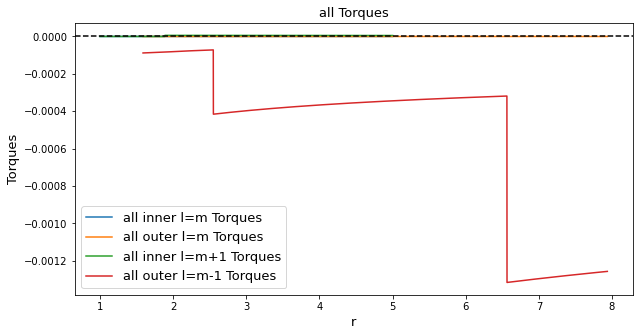

In [23]:
#Plot all Torques
plt.figure(figsize=(10,5))

plt.plot(R_IN,ah1,label='all inner l=m Torques')
plt.plot(R_OUT,ah2,label='all outer l=m Torques')
plt.plot(R_IN,ah3,label='all inner l=m+1 Torques')
plt.plot(R_OUT,ah4,label='all outer l=m-1 Torques')

plt.xlabel('r',fontsize=13)
plt.ylabel('Torques',fontsize=13)
plt.title('all Torques',fontsize=13)
plt.axhline(0, c = "k", linestyle = "--")
plt.legend(fontsize=13)
#plt.ylim([-0.00001,0.00001])

#plt.savefig(f'GT_pictures/torques_gt_{FLARINGINDEX}_{SIGMA_0}_{ALPHAVISCOSITY}_{M1}_{SIGMARATIO}_{H_0}.png')

# Migrationsrate

In [24]:
#Migration rate which results of the angular momentum calculation

#hier mp'= M1+M2
def rate(T,a,M1,M2):
    Sigma= np.sqrt(G*M_STAR/a**3)
    
    rate=2*T/(Sigma*a*(M1+M2))
    return rate

In [25]:
#Sum over the rates to plot them
Torque_all= [sum(x) for x in zip(ah1,ah2,ah3,ah4)]
rate_in= [rate(T,r,M1,M2) for T,r in zip(ah1,R_IN)]
rate_out= [rate(T,r,M1,M2) for T,r in zip(ah2,R_OUT)]
rate_all=[rate(T,r,M1,M2) for T,r in zip(Torque_all,R_IN)]

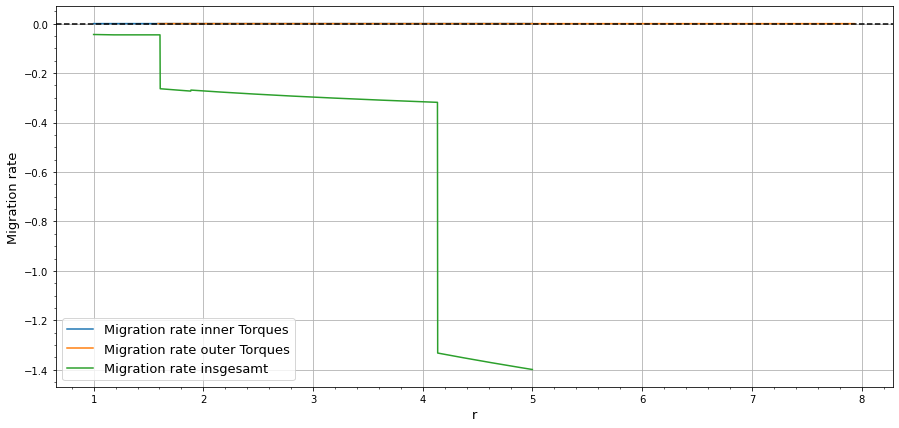

In [26]:
#Plot the rates
plt.figure(figsize=(15,7))
plt.plot(R_IN,rate_in  , label='Migration rate inner Torques')
plt.plot(R_OUT,rate_out, label='Migration rate outer Torques')
plt.plot(R_IN,rate_all, label='Migration rate insgesamt')
plt.xlabel('r',fontsize=13)
plt.ylabel('Migration rate',fontsize=13)
plt.legend(fontsize=13)
plt.axhline(0, c = "k", linestyle = "--")
plt.grid()
plt.minorticks_on()
#plt.savefig(f'GT_pictures_{ec}/rates_gt_{FLARINGINDEX}_{SIGMA_0}_{ALPHAVISCOSITY}_{M1}_{SIGMARATIO}_{H_0}.png')


# Abspeichern der Daten in ein txt file

In [ ]:
orte=BM08newortederrate
index=[int(np.round((i-1)/0.001)) for i in orte]
    

file2write=open(f"BM08GT_{mmr}_{SIGMARATIO}_{ec}.txt",'a+')
file2write.write('newtheory_h0_006_alpha_1e_5_planets_3_1_sigma0_1e_3'+' ' )

file2write.write(str(rate_all[index[9]])+' ')


file2write.write(str(SIGMARATIO)+' ')
file2write.write(str(M1)+' ')
file2write.write(str(FLARINGINDEX)+' ')
file2write.write(str(R_IN[index[9]])+' ')
    
file2write.write('\n')
file2write.close()